In [1]:
#Import Statements

import numpy as np
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
rng = default_rng()

import os
import pandas as pd
import time as time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib as mpl
import glob
import random
import sys
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from os.path import expanduser
home = expanduser("~")
sys.path.append(home+'/repos/ClusNet/code/modules/')

from scipy.ndimage import gaussian_filter
from ClusNet import Cluster
from ClusNet import model as m
from ClusNet import dataset as ds
sys.path.append(home+'/repos/ClusNet/CNN/seg/')
import seg

import glob
import IPython.display as display
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output

# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

Tensorflow ver. 2.4.1


In [2]:
clusglob = glob.glob(home + '/repos/ClusNet/data/eROSITA_no_background/*.fits')

data_length = 50

paths = random.choices(clusglob,k=data_length)
IMG_SIZE = 384
N_CLASSES = 4

In [3]:
modeldir = Cluster.mkdir_model(spath=home+'/repos/ClusNet/models/seg')
x_train,y_train,paths_train,x_test,y_test,paths_test = seg.make_dataset(paths=paths,
                                                                    validation_split=0.90,
                                                                    modeldir=modeldir,
                                                                    shift=False,
                                                                    agn=True,
                                                                    poisson=False,
                                                                    sigma=0.5)



Model directory created --> /Users/erebor/repos/ClusNet/models/seg/BHmtR

Loading 50 cluster(s)...


In [4]:
np.sum(np.ones((384,384,3)),axis=2).shape

(384, 384)

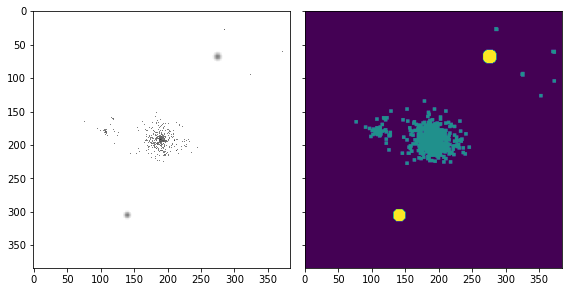

In [5]:
fig, ax = plt.subplots(figsize=(8,5),ncols=2,nrows=1,sharex=True,sharey=True)
idx = np.random.randint(0,x_train.shape[0])
cmap = mpl.cm.binary
norm = mpl.colors.Normalize(vmin=0,vmax=1.)
ax[0].imshow(x_train[idx],cmap=cmap,interpolation='none',norm=norm)
ax[1].imshow(y_train[idx])
plt.show()
plt.close()


In [6]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
dropout_rate = 0.5
N_CHANNELS = 1
input_size = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

# If you want to know more about why we are using `he_normal`:
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excellent fastai course:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)

# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)

In [7]:
the_U = tf.keras.Model(inputs = inputs, outputs = output)
learning_rate = 0.005
#loss = tf.keras.metrics.MeanIoU(num_classes=3)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(lr=learning_rate)

the_U.compile(optimizer=optimizer, 
              loss=loss)

In [2]:
the_U.summary()

In [8]:
epochs = 10
batch_size = 16
validation_split = 0.09

In [9]:
def train_model(model, train_x, train_y, my_epochs, my_batch_size=None, my_validation_split=0.1):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=train_x, y=train_y, batch_size=my_batch_size, epochs=my_epochs, verbose = 1, validation_split=my_validation_split)
    # Gather the model's trained weight and bias.
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]

    # The list of epochs is stored separately from the
    # rest of history.
    epochs = history.epoch
  
    # Isolate the root mean squared error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse, history.history

In [10]:
training_start = time.time()
# Train the model on the normalized training set.
history = the_U.fit(x=y_train, 
                    y=y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_split=validation_split)

epochs = history.epoch
hist = pd.DataFrame(history.history)

print("Training Time: ", (time.time() - training_start)/60)

Epoch 1/10
2/3 [===================>..........] - ETA: 37s - loss: 2107087781888.6489

KeyboardInterrupt: 

In [24]:
print("\n Evaluate the new model against the test set:")
print(the_U.evaluate(x=x_test, y=y_test, batch_size=batch_size))


 Evaluate the new model against the test set:
1/1 [==============================] - 0s 310ms/step - loss: 0.1037
0.10368678718805313


In [13]:
prediction = the_U(x_test, training=False)

In [17]:
print(np.nanmax(prediction))

1.0


In [14]:
def plot_results(x_test,y_test,prediction,seg_cmap=mpl.cm.viridis,spath=None):
    
    if spath is not None:
        figpath = spath + '/res_im/'
        os.mkdir(figpath)

    idx = np.arange(len(prediction))

    for i in random.choices(idx,k=10):
        predict_image = prediction[i].numpy()
        x_test_image = x_test[i]
        y_test_image = y_test[i]

        fig, ax = plt.subplots(figsize =(12,5),nrows=1,ncols=4,sharex=True,sharey=True)
        ax[0].set_title('Input')

        cmap = mpl.cm.binary
        norm = mpl.colors.Normalize(vmin=-2.,vmax=1.)

        ax[0].imshow(np.log10(x_test_image[:,:,0]),cmap=cmap,interpolation='none',norm=norm)

        bounds = [-0.5,0.5,1.5,2.5,3.5]
        norm = mpl.colors.BoundaryNorm(bounds, seg_cmap.N, extend='both')

        """
        cmap = mpl.colors.ListedColormap(['white', 'red','green','blue'])
        bounds = [-0.5,0.5,1.5,2.5,3.5]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        """
        ax[2].set_title('Prediction')
        ax[2].imshow(predict_image[:,:,0], norm = norm, cmap = seg_cmap,aspect=1)


        ax[1].set_title('Truth')
        ax[1].imshow(y_test_image[:,:,0], norm = norm, cmap = seg_cmap,aspect=1)


        ax[-1].set_title('Contrast')
        ax[-1].imshow(predict_image[:,:,0]-y_test_image[:,:,0], norm = norm, cmap = seg_cmap)

        cax = fig.add_axes([1, 0.25, 0.01, 0.5])
        cbar = mpl.colorbar.ColorbarBase(cax, cmap = seg_cmap, norm = norm, ticks=[0,1,2,3])
        for i in range(4):
            #ax[i].axis('off')
            ax[i].set_xticks([])
            ax[i].set_yticks([])

        plt.tight_layout()
        plt.subplots_adjust(wspace=0.05)
        if spath is not None:
            plt.savefig(figpath + '{}.png'.format(i),dpi=200,bbox_inches='tight')
        plt.show()
        plt.close()

<ipython-input-14-b88e8fb46135>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


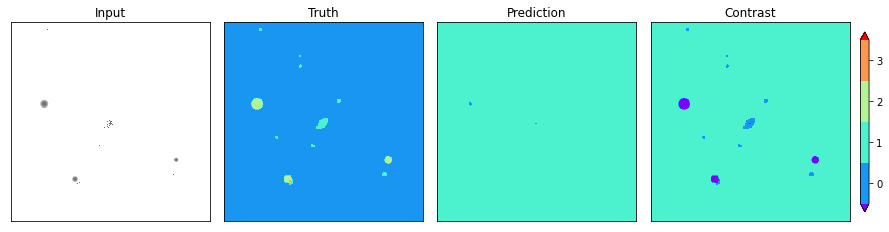

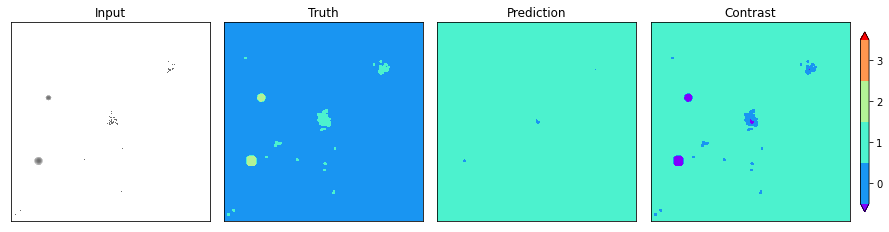

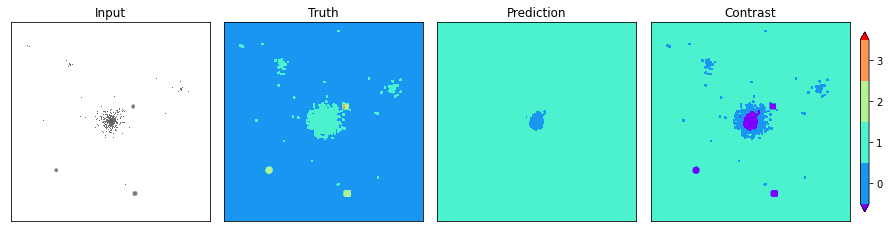

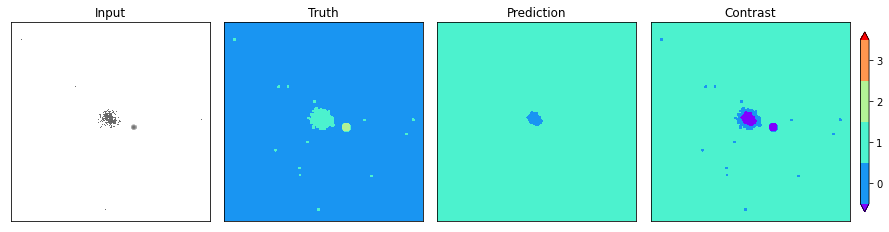

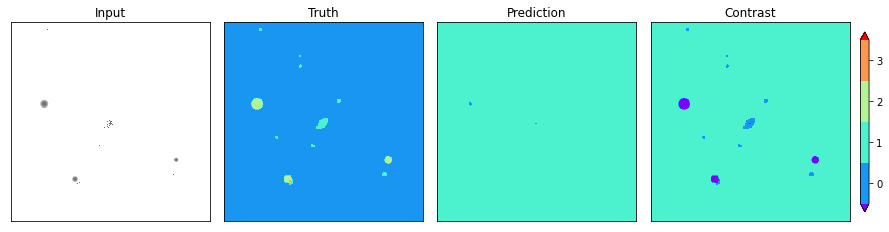

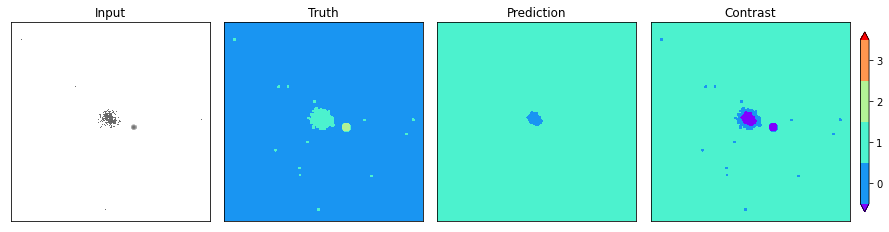

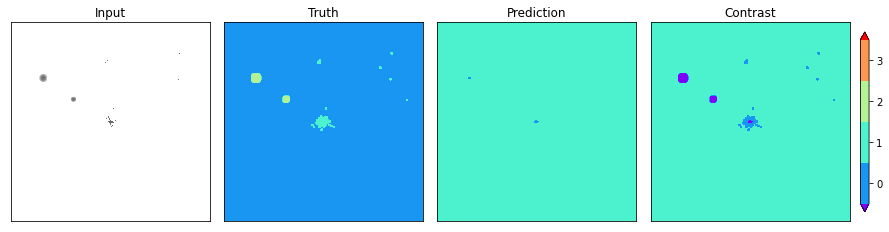

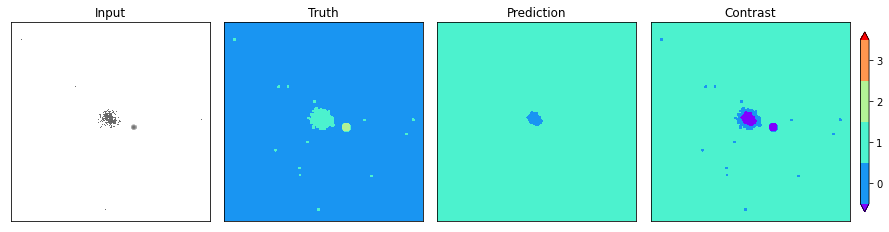

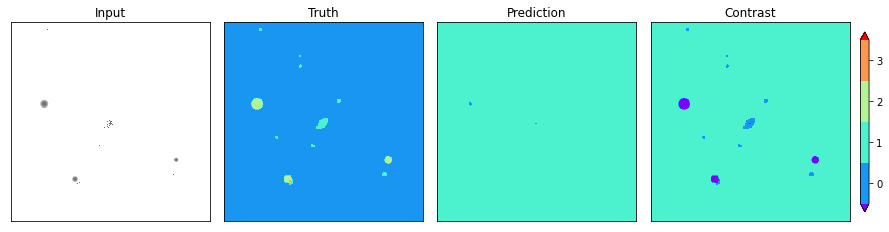

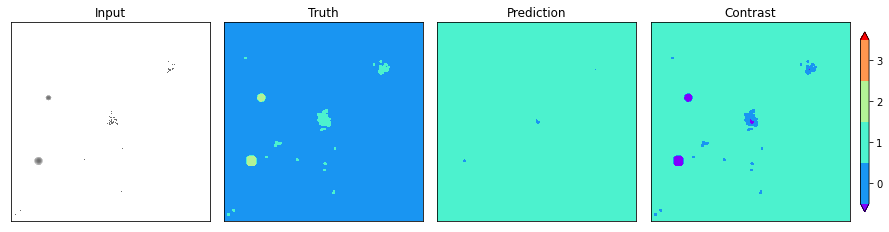

In [15]:
plot_results(x_test=x_test,
             y_test=y_test,
             prediction=prediction,
             seg_cmap=mpl.cm.rainbow,
             spath=None)

In [16]:
x = np.ones((124,124))
y = np.ones((124,124))*2

x[0][1]=0
y[0][1]=0
y[0][3]=1
y[0][4]=0

z = np.array([x+y]).T
print(z.shape)
print(set(z.flatten()))
mask = tf.keras.utils.to_categorical(z, num_classes=3, dtype='float32')
print(type(mask))

(124, 124, 1)
{0.0, 1.0, 2.0, 3.0}


IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
print(test)